# MDI+: Example Usages

In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
sys.path.append("../../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, roc_auc_score, mean_squared_error

from imodels.importance import RandomForestPlusRegressor, RandomForestPlusClassifier, \
    RidgeRegressorPPM, LassoRegressorPPM, IdentityTransformer
from imodels.importance.rf_plus import _fast_r2_score

In [2]:
# helper variables
rf_regressor = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=0.33, random_state=331)
rf_classifier = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, max_features="sqrt", random_state=331)

## 1. Regression Example

In [3]:
# generate data from linear model: y = x1 + x2 + N(0, 1)
n = 200
p = 10
s = 2
X = np.random.normal(size=(n, p))
beta = np.concatenate((np.ones(s), np.zeros(p-s)))
y = np.matmul(X, beta) + np.random.normal(size=n)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=12345)

### 1.1 Local MDI+ (Feature Contribution) w/ Regression

In [4]:
# fit RF+
rf_plus_model = RandomForestPlusRegressor(rf_model=rf_regressor, include_raw=False)
rf_plus_model.fit(X_train, y_train)

In [5]:
# make predictions with RF+
preds = rf_plus_model.predict(X_test)
r2_score(y_test, preds)

0.30899228590170735

#### Leave-One-Out Coefficients: $LFI(i,k)=\sum_{j=1}^p|\hat{\beta}^{(k)}_{-i,j}*\Psi^{(k)}_{i,j}|$

In [6]:
# get MDI+ scores (higher r^2 value = greater importance)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train, lfi=True,
                                                    lfi_abs = "inside")

Local MDI+ w/ Leave-One-Out Coefficients and Inner Absolute Value
------------------------------------
            0         1         2         3         4         5         6  \
0    0.472798  0.347425  0.135774  0.091139  0.055561  0.035184  0.074879   
1    0.376736  0.456944  0.167200  0.070448  0.058099  0.048969  0.072266   
2    0.386960  0.444739  0.141176  0.072743  0.059939  0.052859  0.076358   
3    0.346125  0.448199  0.161850  0.098282  0.071044  0.035281  0.065749   
4    0.729269  0.348829  0.101246  0.050617  0.028775  0.051951  0.053812   
..        ...       ...       ...       ...       ...       ...       ...   
129  0.442472  0.462125  0.158956  0.060977  0.048551  0.040555  0.055292   
130  0.758537  0.377407  0.109393  0.070444  0.042978  0.041684  0.055146   
131  0.344376  0.309148  0.099642  0.054501  0.049685  0.014940  0.052841   
132  0.779559  0.366274  0.083009  0.047365  0.040717  0.030966  0.046699   
133  0.685004  0.342746  0.080162  0.036487  0.080

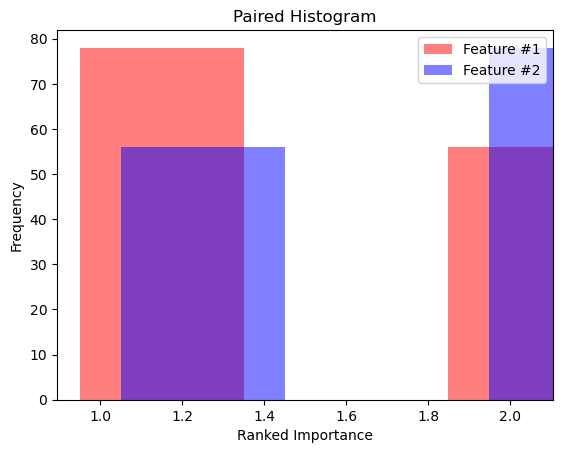

In [7]:
print("Local MDI+ w/ Leave-One-Out Coefficients and Inner Absolute Value")
print("------------------------------------")
lfi_loo_inner = mdi_plus_scores["lfi"]
print(lfi_loo_inner)
print("------------------------------------")
print("Recall that the first two columns are the only ones with signal.")
print("Histogram of Rank of First Column (Red) and Second Column (Blue)")
lfi_rank = lfi_loo_inner.rank(axis=1, method="dense", ascending=False)
fig, ax = plt.subplots()
ax.hist(lfi_rank.iloc[:, 0], alpha = 0.5, label='Feature #1', align = "left",
        width = 0.4, color = "red")
ax.hist(lfi_rank.iloc[:, 1], alpha = 0.5, label='Feature #2', align = "right",
        width = 0.4, color = "blue")
ax.set_xlabel('Ranked Importance')
ax.set_ylabel('Frequency')
ax.set_title('Paired Histogram')
ax.legend()
plt.show()

#### Leave-One-Out Coefficients: $LFI(i,k)=|\sum_{j=1}^p\hat{\beta}^{(k)}_{-i,j}*\Psi^{(k)}_{i,j}|$

In [8]:
# get MDI+ scores (higher r^2 value = greater importance)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train, lfi=True,
                                                    lfi_abs = "outside")

Local MDI+ w/ Leave-One-Out Coefficients and Outer Absolute Value
------------------------------------
            0         1         2         3         4         5         6  \
0    0.328245  0.285862  0.129168  0.082738  0.052899  0.033555  0.069087   
1    0.232859  0.446129  0.144025  0.061473  0.052743  0.047745  0.065900   
2    0.244927  0.320079  0.131168  0.062549  0.056136  0.045452  0.068914   
3    0.216040  0.412837  0.131011  0.093423  0.067016  0.034478  0.064467   
4    0.681966  0.278756  0.095001  0.045777  0.023957  0.045388  0.047720   
..        ...       ...       ...       ...       ...       ...       ...   
129  0.320690  0.441736  0.126362  0.055501  0.040242  0.039110  0.053957   
130  0.743288  0.348818  0.105863  0.068370  0.037192  0.041034  0.049423   
131  0.262489  0.289444  0.091525  0.048481  0.041920  0.014241  0.044270   
132  0.758131  0.308151  0.070420  0.045997  0.036778  0.029149  0.040252   
133  0.659369  0.273716  0.074327  0.033977  0.079

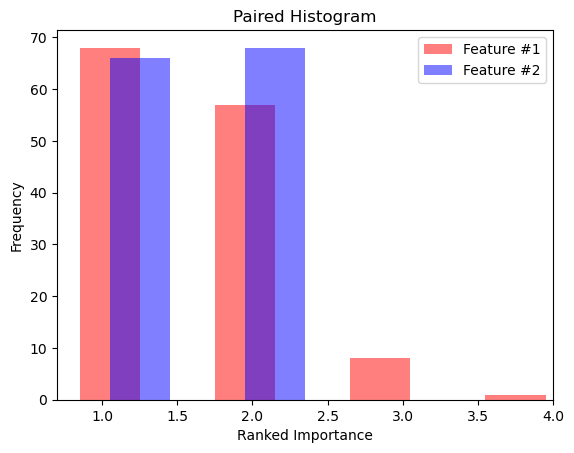

In [9]:
print("Local MDI+ w/ Leave-One-Out Coefficients and Outer Absolute Value")
print("------------------------------------")
lfi_loo_outer = mdi_plus_scores["lfi"]
print(lfi_loo_outer)
print("------------------------------------")
print("Recall that the first two columns are the only ones with signal.")
print("Histogram of Rank of First Column (Red) and Second Column (Blue)")
lfi_rank = lfi_loo_outer.rank(axis=1, method="dense", ascending=False)
fig, ax = plt.subplots()
ax.hist(lfi_rank.iloc[:, 0], alpha = 0.5, label='Feature #1', align = "left",
        width = 0.4, color = "red")
ax.hist(lfi_rank.iloc[:, 1], alpha = 0.5, label='Feature #2', align = "right",
        width = 0.4, color = "blue")
ax.set_xlabel('Ranked Importance')
ax.set_ylabel('Frequency')
ax.set_title('Paired Histogram')
ax.legend()
plt.show()

#### Leave-One-Out Coefficients: $LFI(i,k)=\sum_{j=1}^p\hat{\beta}^{(k)}_{-i,j}*\Psi^{(k)}_{i,j}$

In [10]:
# get MDI+ scores (higher r^2 value = greater importance)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train, lfi=True,
                                                    lfi_abs = "none")

Local MDI+ w/ Leave-One-Out Coefficients and Outer Absolute Value
------------------------------------
            0         1         2         3         4         5         6  \
0    0.177723 -0.205256  0.051019  0.074054 -0.014222  0.004002  0.039713   
1   -0.041268 -0.440976  0.125411  0.018681  0.001172  0.022805  0.014183   
2   -0.121388 -0.176087  0.111497  0.036303 -0.005032 -0.022637 -0.000426   
3   -0.116099 -0.409611  0.114290  0.088787 -0.040496 -0.022122 -0.004224   
4    0.660067 -0.215194  0.088038  0.015907 -0.006090  0.011911  0.020945   
..        ...       ...       ...       ...       ...       ...       ...   
129  0.143588 -0.435906  0.102654  0.021931 -0.004062  0.010862 -0.030685   
130  0.738226 -0.344737  0.099295 -0.059288 -0.019823  0.007528  0.010639   
131 -0.187426 -0.263751  0.069429  0.031573  0.025429  0.009303  0.018852   
132  0.754154  0.226117  0.039488 -0.000472 -0.031122  0.021810 -0.018896   
133  0.647824  0.199306  0.061452 -0.008061  0.062

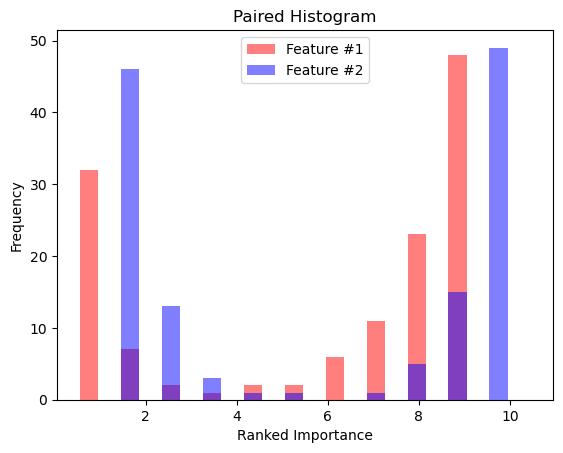

In [11]:
print("Local MDI+ w/ Leave-One-Out Coefficients and Outer Absolute Value")
print("------------------------------------")
lfi_loo_outer = mdi_plus_scores["lfi"]
print(lfi_loo_outer)
print("------------------------------------")
print("Recall that the first two columns are the only ones with signal.")
print("Histogram of Rank of First Column (Red) and Second Column (Blue)")
lfi_rank = lfi_loo_outer.rank(axis=1, method="dense", ascending=False)
fig, ax = plt.subplots()
ax.hist(lfi_rank.iloc[:, 0], alpha = 0.5, label='Feature #1', align = "left",
        width = 0.4, color = "red")
ax.hist(lfi_rank.iloc[:, 1], alpha = 0.5, label='Feature #2', align = "right",
        width = 0.4, color = "blue")
ax.set_xlabel('Ranked Importance')
ax.set_ylabel('Frequency')
ax.set_title('Paired Histogram')
ax.legend()
plt.show()